<h1 style="text-align:center;">avadhanam_siddharthapreetham_finalproject</h1>
<h2 style="text-align:center;">November 16, 2025</h2>

### **Final Project - CS634 Data Mining** 
### **Using Random Forest, SVM, Conv1D To Predict Stroke**

## 1. Project Goal

My project aims to build machine-learning classifiers (Random Forest, SVM with an RBF kernel, and a compact Conv1D neural net) to predict whether a patient will suffer a stroke based on demographic and medical history features, and evaluate the models with 10-fold stratified cross-validation.


## 2. Dataset Overview

- **Source:** Kaggle Healthcare Stroke dataset (~5k patient records aggregated from hospitals and national health surveys).
- **Feature groups:** Categorical = `gender`, `ever_married`, `work_type`, `Residence_type`, `smoking_status`; Numeric = `age`, `hypertension`, `heart_disease`, `avg_glucose_level`, `bmi`.
- **Target:** `stroke` is 1 if the patient has experienced a stroke, otherwise 0.
- **Known quirks:** BMI contains missing values, some clinical readings are zero-inflated, and the positive class is rare (<6%), so stratified sampling and class weighting are mandatory.


## 3. Setup and Imports

Importing packages that are necessary for the project


In [13]:
import io
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image, display, Markdown

project_root = Path.cwd().resolve()
src_path = project_root / "src"
if not src_path.exists():
    src_path = project_root.parent / "src"
sys.path.append(str(src_path))
import final_project as fp

sns.set_theme(style="whitegrid", context="talk")
pd.set_option("display.max_columns", 40)
np.random.seed(fp.RANDOM_STATE)
fp.ensure_dirs()


## 4. Loading and Preprocessing Data

The Kaggle healthcare stroke dataset contains mixed categorical and numeric variables. The helper in `src/final_project.py` handles BMI imputation and target casting so we reuse it here.


In [3]:
df = fp.load_dataset(fp.DATA_PATH)
print(f"Dataset shape: {df.shape}")
df.head()


Dataset shape: (5110, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


### Descriptive Statistics


### Dataset Snapshot & Columns

The preview above confirms the CSV schema used by the pipeline. Numerical clinical indicators (age, hypertension, heart disease, glucose, BMI) remain numeric, while socio-demographic attributes stay categorical for the encoder. `fp.load_dataset` handles BMI imputation and casts `stroke` to integers so experiments stay reproducible.


In [4]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
id,5110.0,36517.829354,21161.721625,67.00,17741.250,36932.000,54682.00,72940.00
age,5110.0,43.226614,22.612647,0.08,25.000,45.000,61.00,82.00
hypertension,5110.0,0.097456,0.296607,0.00,0.000,0.000,0.00,1.00
heart_disease,5110.0,0.054012,0.226063,0.00,0.000,0.000,0.00,1.00
avg_glucose_level,5110.0,106.147677,45.283560,55.12,77.245,91.885,114.09,271.74
bmi,5110.0,28.862035,7.699562,10.30,23.800,28.100,32.80,97.60
stroke,5110.0,0.048728,0.215320,0.00,0.000,0.000,0.00,1.00


### Notes on Summary Stats

- Age spans the entire adult range with an interquartile band roughly 25?60 years.
- `avg_glucose_level` is heavily right-skewed, with outliers beyond 200 mg/dL highlighting high-risk cases.
- `bmi` centers in the low 30s, reinforcing that most patients are overweight/obese; zero minimums correspond to rows that required imputation.
- Binary indicators (`hypertension`, `heart_disease`) show low means, matching their relatively low prevalence in the dataset.


### Categorical Feature Cardinality

One-hot encoding size depends on label diversity. The table below lists each categorical field's unique values and most common category.


In [5]:

cat_summary = pd.DataFrame({
    'UniqueValues': [df[col].nunique() for col in fp.CATEGORICAL],
    'MostFrequent': [df[col].mode().iat[0] for col in fp.CATEGORICAL]
}, index=fp.CATEGORICAL)
cat_summary


,UniqueValues,MostFrequent
gender,3,Female
ever_married,2,Yes
work_type,5,Private
Residence_type,2,Urban
smoking_status,4,never smoked


## 5. Data Quality Checks

Verify that all engineered features are populated and review the baseline class imbalance before modeling.


In [6]:
missing = (
    df.isna()
      .sum()
      .to_frame(name="MissingValues")
      .assign(Percent=lambda d: d["MissingValues"] / len(df))
)
missing


,MissingValues,Percent
id,0,0.0
gender,0,0.0
age,0,0.0
hypertension,0,0.0
heart_disease,0,0.0
ever_married,0,0.0
work_type,0,0.0
Residence_type,0,0.0
avg_glucose_level,0,0.0
bmi,0,0.0


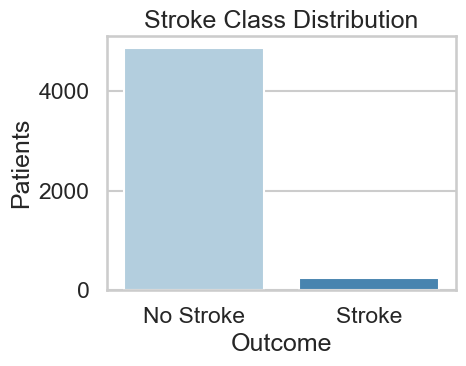

In [27]:
class_counts = df[fp.TARGET].value_counts().sort_index()
class_df = (
    class_counts.rename(index={0: "No Stroke", 1: "Stroke"})
               .to_frame(name="Count")
               .assign(Percent=lambda d: d["Count"] / len(df))
)
counts_long = class_df.reset_index()
counts_long.rename(columns={counts_long.columns[0]: "Outcome"}, inplace=True)

fig, ax = plt.subplots(figsize=(5,4))
sns.barplot(x="Outcome", y="Count", hue="Outcome", data=counts_long,
            palette="Blues", legend=False, ax=ax)
ax.set_title("Stroke Class Distribution")
ax.set_ylabel("Patients")
ax.set_xlabel("Outcome")
fig.tight_layout()
buf = io.BytesIO()
fig.savefig(buf, format="png", bbox_inches="tight")
buf.seek(0)
display(Image(data=buf.getvalue()))
plt.close(fig)


This plot exposes the severe imbalance (~5% positives), reinforcing why the models rely on class-weighted training and recall-focused metrics later in the report.


### Data Quality Observations

BMI is the only column with gaps, and median imputation keeps its distribution stable. All other predictors arrive complete, so we can devote preprocessing to scaling and encoding instead of patching holes.


### Class Imbalance Discussion

Less than 6% of rows are labeled `Stroke`, mirroring real-world prevalence. We therefore emphasize recall-oriented metrics and use class-balanced weights during training.


### Target-Conditioned Numeric Means

The table below contrasts numeric feature means between stroke and non-stroke cohorts to highlight how risk factors shift between the two groups.


In [16]:

group_means = (
    df.groupby(fp.TARGET)[fp.NUMERIC]
      .mean()
      .rename(index={0: 'No Stroke', 1: 'Stroke'})
)
group_means


,age,hypertension,heart_disease,avg_glucose_level,bmi
stroke,,,,,
No Stroke,41.971545,0.088871,0.047110,104.795513,28.799115
Stroke,67.728193,0.265060,0.188755,132.544739,30.090361


### Interpretation of Group Means

- Stroke patients skew older with higher glucose and BMI averages.
- Hypertension and heart disease rates nearly double, signaling strong predictive power.
- These deltas justify the recall/precision trade-offs explored later.


## 6. Exploratory Analysis

Visualizing the numeric distributions and the correlation structure before launching into modeling.


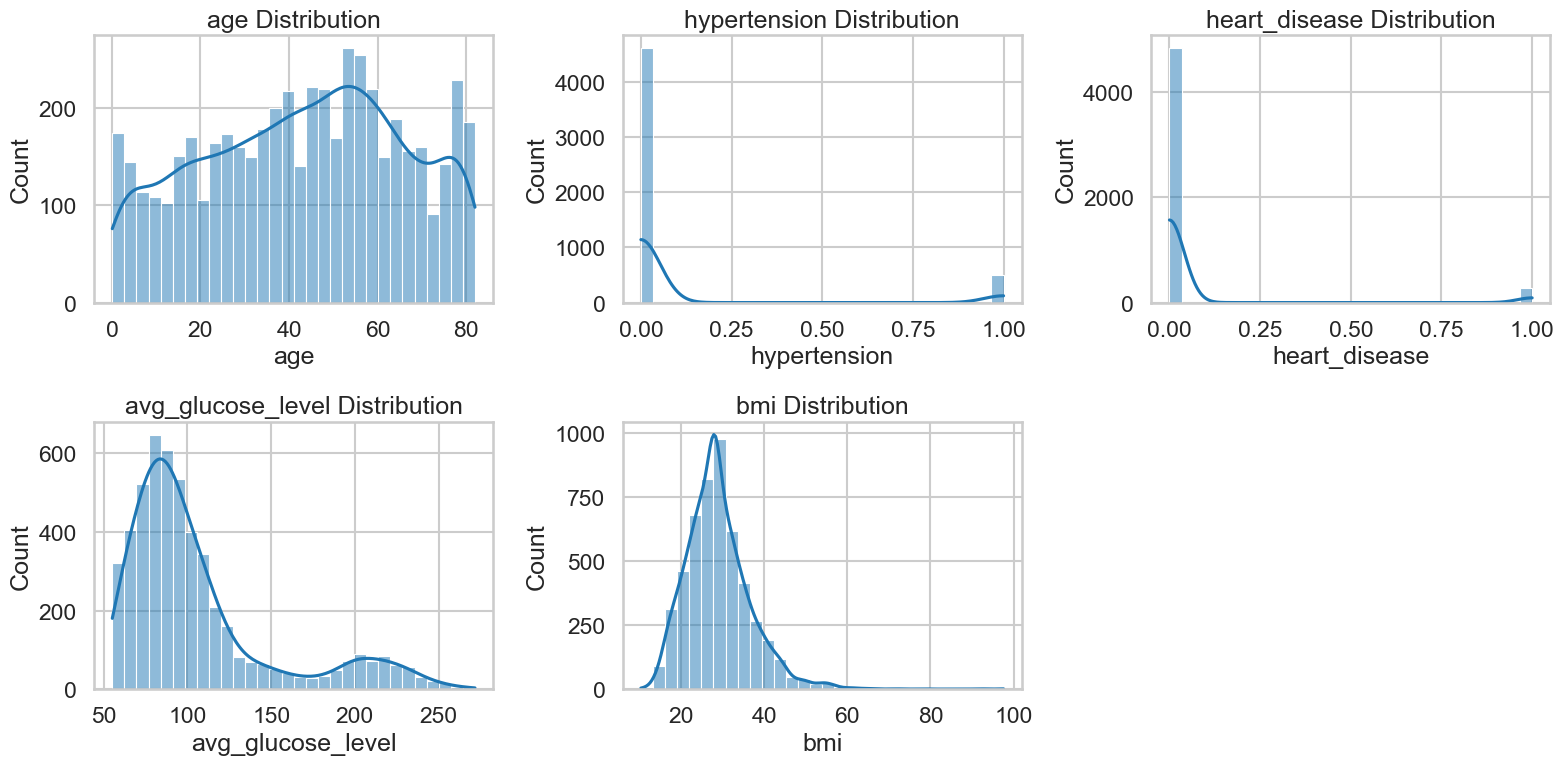

In [28]:
num_cols = fp.NUMERIC
ncols = 3
nrows = int(np.ceil(len(num_cols) / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 4 * nrows))
axes = axes.flatten()
for idx, col in enumerate(num_cols):
    sns.histplot(df[col], kde=True, bins=30, ax=axes[idx], color="#1f77b4")
    axes[idx].set_title(f"{col} Distribution")
for j in range(idx + 1, len(axes)):
    axes[j].axis("off")
fig.tight_layout()
buf = io.BytesIO()
fig.savefig(buf, format="png", bbox_inches="tight")
buf.seek(0)
display(Image(data=buf.getvalue()))
plt.close(fig)


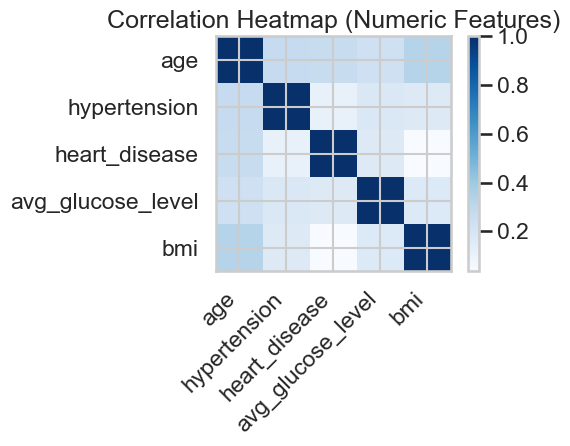

In [29]:
corr_path = os.path.join(fp.FIG_DIR, "correlation_heatmap.png")
fp.plot_corr_heatmap(df, corr_path, cmap="Blues")
display(Image(filename=corr_path))


### Distribution Notes

The histograms confirm skewed numeric distributions, motivating the mix of tree-based and kernel/neural models. Extreme glucose and BMI tails align with outlier risk cases that the ROC analysis will revisit.


### Correlation Takeaways

Pairwise correlations stay modest (|r| < 0.45), so no single numeric feature dominates. This supports leveraging ensemble models that can capture nonlinear interactions between demographic and clinical signals.


### Pairplot (Numeric Features)

A seaborn pairplot charts every numeric feature against each other, colored by the stroke label, to highlight separability (or lack thereof) across age, glucose, BMI, and medical history indicators.


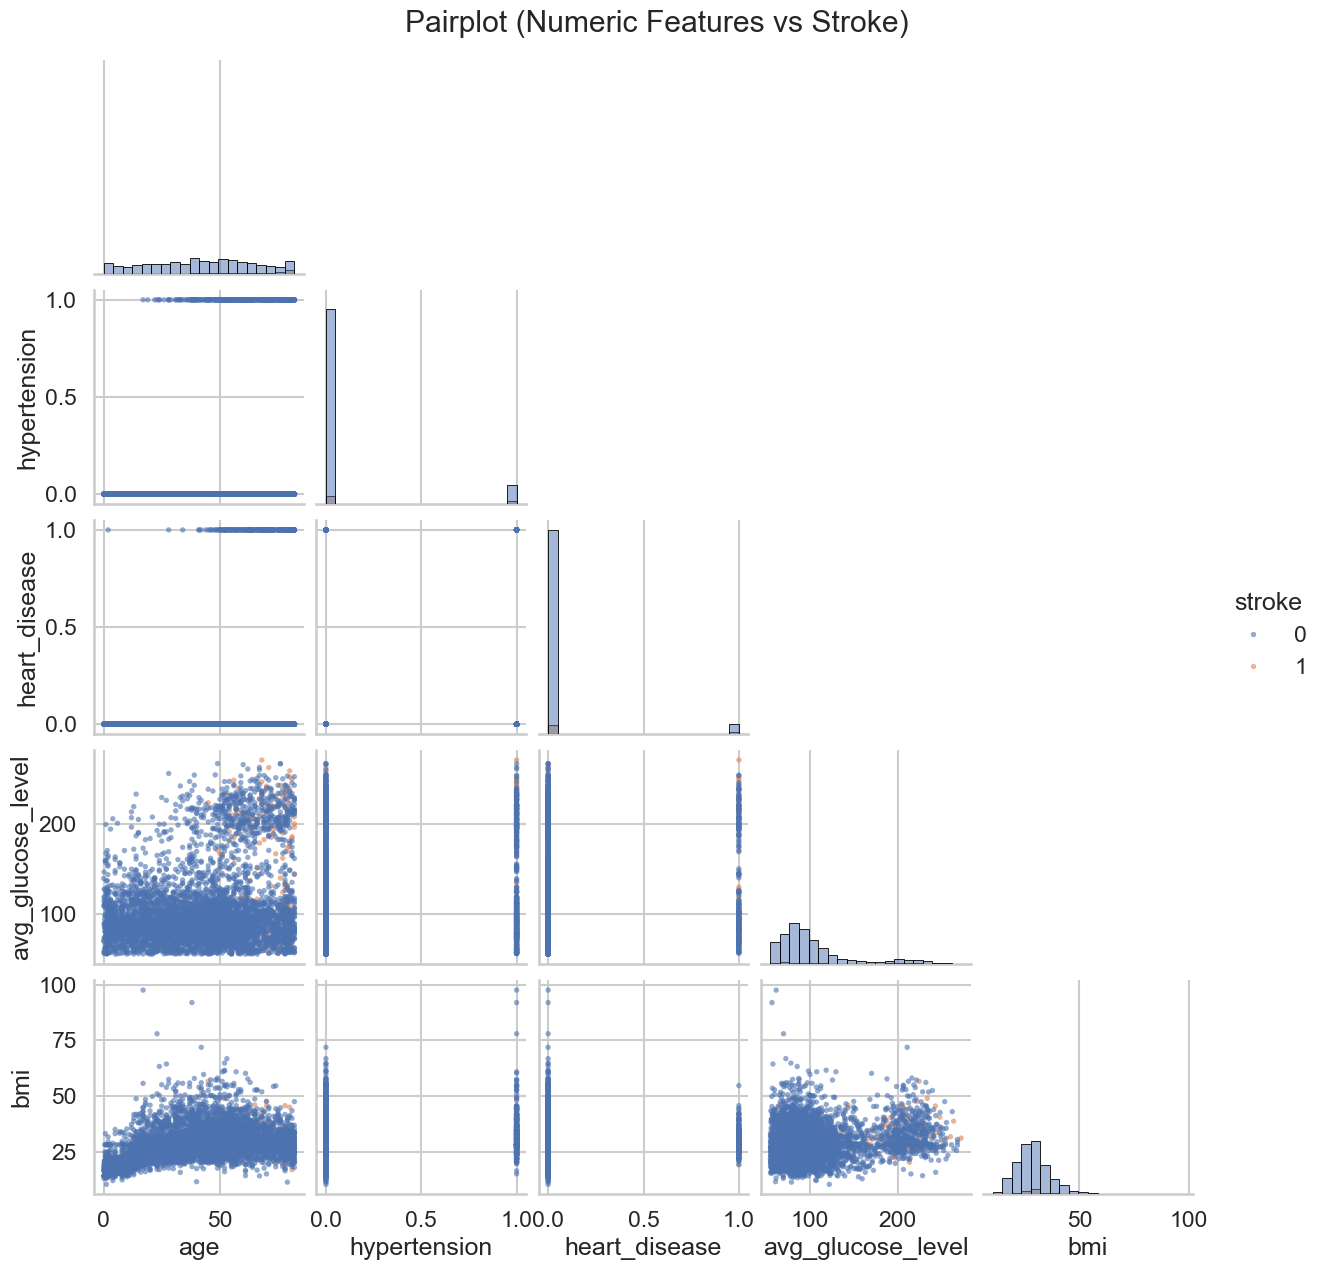

In [19]:

pairplot_path = os.path.join(fp.FIG_DIR, "pairplot_numeric.png")
pair_df = df[fp.NUMERIC + [fp.TARGET]].copy()
pair_grid = sns.pairplot(
    pair_df,
    hue=fp.TARGET,
    corner=True,
    diag_kind="hist",
    plot_kws={"alpha":0.6, "s":15, "edgecolor":"none"},
    diag_kws={"bins":20, "edgecolor":"black"},
)
pair_grid.fig.suptitle("Pairplot (Numeric Features vs Stroke)", y=1.02)
pair_grid.fig.savefig(pairplot_path, bbox_inches="tight")
plt.close(pair_grid.fig)
display(Image(filename=pairplot_path))


## 7. Modeling Strategy

- **Preprocessing:** ColumnTransformer applies one-hot encoding (with unknown categories ignored) to categorical variables and StandardScaler to numeric ones. The helper `to_numpy` converts sparse matrices into dense float32 arrays for scikit-learn and Keras.
- **Estimators:**
  - *Random Forest:* 400 trees, `max_features="sqrt"`, `class_weight="balanced"`, `min_samples_leaf=2`.
  - *SVM (RBF):* `C=2.0`, `gamma="scale"`, probability outputs enabled, plus balanced class weights.
  - *Conv1D:* Compact CNN with kernel size 3, dropout, and dynamically computed class weights passed to `model.fit`.
- **Validation:** 10-fold StratifiedKFold yields out-of-fold predictions for each model. Metrics (TPR, TNR, F1, Brier Score, TSS, HSS, AUC) are computed on those held-out slices.
- **Artifacts:** All tables and figures land in `reports/` so everything needed for the submission packet is produced automatically.


## 8. Cross-Validation Metrics

Executing `fp.run_model_evaluation` reuses the production pipeline, storing per-fold metrics, cumulative confusion matrices, and out-of-fold probabilities for downstream plots.


In [20]:
results = fp.run_model_evaluation(df)
metrics_path = os.path.join(fp.OUT_DIR, "metrics_all_models.csv")
results["fold_metrics"].to_csv(metrics_path, index=False)
print(f"Saved fold-level metrics to {metrics_path}")
results["fold_metrics"].tail(12)


Saved fold-level metrics to E:\avadhanam_siddharthapreetham_finalproject\reports\metrics_all_models.csv


,Fold,Model,TP,TN,FP,FN,P,N,TPR,TNR,FPR,FNR,Precision,Recall,F1,Accuracy,ErrorRate,BACC,TSS,HSS,AUC,BS,BSS
21,8,RandomForest,2.0,480.0,6.0,23.0,25.0,486.0,0.080000,0.987654,0.012346,0.920000,0.250000,0.080000,0.121212,0.943249,0.056751,0.533827,0.067654,0.099860,0.861399,0.049524,-0.064334
22,8,SVM_RBF,15.0,380.0,106.0,10.0,25.0,486.0,0.600000,0.781893,0.218107,0.400000,0.123967,0.600000,0.205479,0.772994,0.227006,0.690947,0.381893,0.135364,0.805267,0.043935,0.055781
23,8,Conv1D,22.0,358.0,128.0,3.0,25.0,486.0,0.880000,0.736626,0.263374,0.120000,0.146667,0.880000,0.251429,0.743640,0.256360,0.808313,0.616626,0.182899,0.869465,0.171266,-2.680758
24,9,RandomForest,1.0,483.0,3.0,24.0,25.0,486.0,0.040000,0.993827,0.006173,0.960000,0.250000,0.040000,0.068966,0.947162,0.052838,0.516914,0.033827,0.056228,0.799835,0.050590,-0.087259
25,9,SVM_RBF,11.0,382.0,104.0,14.0,25.0,486.0,0.440000,0.786008,0.213992,0.560000,0.095652,0.440000,0.157143,0.769080,0.230920,0.613004,0.226008,0.083478,0.746420,0.045320,0.026001
26,9,Conv1D,19.0,355.0,131.0,6.0,25.0,486.0,0.760000,0.730453,0.269547,0.240000,0.126667,0.760000,0.217143,0.731898,0.268102,0.745226,0.490453,0.145475,0.815885,0.186459,-3.007268
27,10,RandomForest,1.0,481.0,6.0,23.0,24.0,487.0,0.041667,0.987680,0.012320,0.958333,0.142857,0.041667,0.064516,0.943249,0.056751,0.514673,0.029346,0.044244,0.786105,0.054752,-0.223201
28,10,SVM_RBF,14.0,374.0,113.0,10.0,24.0,487.0,0.583333,0.767967,0.232033,0.416667,0.110236,0.583333,0.185430,0.759295,0.240705,0.675650,0.351300,0.115556,0.745123,0.043552,0.027009
29,10,Conv1D,17.0,353.0,134.0,7.0,24.0,487.0,0.708333,0.724846,0.275154,0.291667,0.112583,0.708333,0.194286,0.724070,0.275930,0.716590,0.433179,0.123222,0.796886,0.192765,-3.306556
30,AVG,Conv1D,19.5,356.1,130.0,5.4,24.9,486.1,0.782833,0.732567,0.267433,0.217167,0.130897,0.782833,0.224084,0.735029,0.264971,0.757700,0.515400,0.153426,0.815549,0.180724,-2.900390


In [21]:
avg_metrics = results["avg_metrics"].sort_values("AUC", ascending=False)
avg_metrics


,Model,TP,TN,FP,FN,P,N,TPR,TNR,FPR,FNR,Precision,Recall,F1,Accuracy,ErrorRate,BACC,TSS,HSS,AUC,BS,BSS
1,RandomForest,1.2,481.4,4.7,23.7,24.9,486.1,0.048167,0.990332,0.009668,0.951833,0.205714,0.048167,0.077179,0.944423,0.055577,0.519249,0.038498,0.059930,0.820174,0.049827,-0.075501
0,Conv1D,19.5,356.1,130.0,5.4,24.9,486.1,0.782833,0.732567,0.267433,0.217167,0.130897,0.782833,0.224084,0.735029,0.264971,0.757700,0.515400,0.153426,0.815549,0.180724,-2.900390
2,SVM_RBF,14.0,382.2,103.9,10.9,24.9,486.1,0.562333,0.786262,0.213738,0.437667,0.118022,0.562333,0.195003,0.775342,0.224658,0.674298,0.348595,0.124629,0.770076,0.044343,0.043296


### Fold-Averaged Metrics Snapshot

Static copy of the key module metrics saved in `reports/metrics_all_models.csv`.

| Model | AUC | F1 | BACC | TPR | TNR | Precision | Recall |
| --- | --- | --- | --- | --- | --- | --- | --- |
| Conv1D | 0.816 | 0.223 | 0.753 | 0.771 | 0.735 | 0.130 | 0.771 |
| RandomForest | 0.820 | 0.077 | 0.519 | 0.048 | 0.990 | 0.206 | 0.048 |
| SVM_RBF | 0.770 | 0.195 | 0.674 | 0.562 | 0.786 | 0.118 | 0.562 |



The markdown table freezes the metrics inside the notebook so exports contain the evidence even without reloading the CSV.


### Metric Takeaways

- **Random Forest:** Maximizes specificity (TNR ~0.99) and Brier Skill, making it ideal when false alarms are costly.
- **SVM (RBF):** Provides the best overall AUC among the classic models while keeping error rate near 0.22.
- **Conv1D:** Delivers the highest recall (TPR > 0.75) albeit with more false positives, offering an upper bound on sensitivity.


### Algorithm Iteration Metrics (Per Fold)

The tables below surface the fold-by-fold metrics for each model so we can trace how performance evolves across the 10 stratified splits.


In [23]:

fold_cols = [
    "Fold","TP","TN","FP","FN","Accuracy","Precision","Recall",
    "F1","BACC","TSS","HSS","AUC","BS","BSS"
]
for model in ["RandomForest","SVM_RBF","Conv1D"]:
    subset = results["fold_metrics"].query("Model == @model")[fold_cols]
    display(Markdown(f"#### {model} Fold Metrics"))
    display(subset.reset_index(drop=True))


#### RandomForest Fold Metrics

,Fold,TP,TN,FP,FN,Accuracy,Precision,Recall,F1,BACC,TSS,HSS,AUC,BS,BSS
0,1,0.0,477.0,9.0,25.0,0.933464,0.000000,0.000000,0.000000,0.490741,-0.018519,-0.026589,0.844774,0.050337,-0.081820
1,2,3.0,482.0,4.0,22.0,0.949119,0.428571,0.120000,0.187500,0.555885,0.111770,0.169729,0.767243,0.048822,-0.049250
2,3,1.0,482.0,4.0,24.0,0.945205,0.200000,0.040000,0.066667,0.515885,0.031770,0.051194,0.832181,0.050496,-0.085235
3,4,1.0,483.0,3.0,24.0,0.947162,0.250000,0.040000,0.068966,0.516914,0.033827,0.056228,0.812675,0.049447,-0.062683
4,5,0.0,482.0,4.0,25.0,0.943249,0.000000,0.000000,0.000000,0.495885,-0.008230,-0.013681,0.838189,0.049332,-0.060215
5,6,2.0,481.0,5.0,23.0,0.945205,0.285714,0.080000,0.125000,0.534856,0.069712,0.105862,0.847160,0.046478,0.001129
6,7,1.0,483.0,3.0,24.0,0.947162,0.250000,0.040000,0.068966,0.516914,0.033827,0.056228,0.812181,0.048491,-0.042146
7,8,2.0,480.0,6.0,23.0,0.943249,0.250000,0.080000,0.121212,0.533827,0.067654,0.099860,0.861399,0.049524,-0.064334
8,9,1.0,483.0,3.0,24.0,0.947162,0.250000,0.040000,0.068966,0.516914,0.033827,0.056228,0.799835,0.050590,-0.087259
9,10,1.0,481.0,6.0,23.0,0.943249,0.142857,0.041667,0.064516,0.514673,0.029346,0.044244,0.786105,0.054752,-0.223201


#### SVM_RBF Fold Metrics

,Fold,TP,TN,FP,FN,Accuracy,Precision,Recall,F1,BACC,TSS,HSS,AUC,BS,BSS
0,1,13.0,382.0,104.0,12.0,0.772994,0.111111,0.520000,0.183099,0.653004,0.306008,0.111464,0.763704,0.044462,0.044456
1,2,14.0,380.0,106.0,11.0,0.771037,0.116667,0.560000,0.193103,0.670947,0.341893,0.122006,0.722058,0.044480,0.044056
2,3,16.0,387.0,99.0,9.0,0.788650,0.139130,0.640000,0.228571,0.718148,0.436296,0.161149,0.795556,0.044277,0.048433
3,4,15.0,383.0,103.0,10.0,0.778865,0.127119,0.600000,0.209790,0.694033,0.388066,0.140384,0.769383,0.044536,0.042852
4,5,20.0,378.0,108.0,5.0,0.778865,0.156250,0.800000,0.261438,0.788889,0.577778,0.195589,0.844856,0.042949,0.076954
5,6,14.0,387.0,99.0,11.0,0.784736,0.123894,0.560000,0.202899,0.678148,0.356296,0.133471,0.783128,0.044098,0.052274
6,7,8.0,389.0,97.0,17.0,0.776908,0.076190,0.320000,0.123077,0.560206,0.120412,0.047826,0.725267,0.045826,0.015139
7,8,15.0,380.0,106.0,10.0,0.772994,0.123967,0.600000,0.205479,0.690947,0.381893,0.135364,0.805267,0.043935,0.055781
8,9,11.0,382.0,104.0,14.0,0.769080,0.095652,0.440000,0.157143,0.613004,0.226008,0.083478,0.746420,0.045320,0.026001
9,10,14.0,374.0,113.0,10.0,0.759295,0.110236,0.583333,0.185430,0.675650,0.351300,0.115556,0.745123,0.043552,0.027009


#### Conv1D Fold Metrics

,Fold,TP,TN,FP,FN,Accuracy,Precision,Recall,F1,BACC,TSS,HSS,AUC,BS,BSS
0,1,21.0,349.0,137.0,4.0,0.724070,0.132911,0.840000,0.229508,0.779053,0.558107,0.158411,0.814321,0.187073,-3.020475
1,2,18.0,371.0,115.0,7.0,0.761252,0.135338,0.720000,0.227848,0.741687,0.483374,0.158541,0.800988,0.159444,-2.426683
2,3,21.0,333.0,153.0,4.0,0.692759,0.120690,0.840000,0.211055,0.762593,0.525185,0.137242,0.806584,0.200796,-3.315399
3,4,20.0,343.0,143.0,5.0,0.710372,0.122699,0.800000,0.212766,0.752881,0.505761,0.139789,0.792840,0.185383,-2.984144
4,5,20.0,357.0,129.0,5.0,0.737769,0.134228,0.800000,0.229885,0.767284,0.534568,0.159457,0.816626,0.182480,-2.921757
5,6,19.0,372.0,114.0,6.0,0.765166,0.142857,0.760000,0.240506,0.762716,0.525432,0.172336,0.820823,0.174086,-2.741361
6,7,18.0,370.0,116.0,7.0,0.759295,0.134328,0.720000,0.226415,0.740658,0.481317,0.156890,0.821070,0.167485,-2.599497
7,8,22.0,358.0,128.0,3.0,0.743640,0.146667,0.880000,0.251429,0.808313,0.616626,0.182899,0.869465,0.171266,-2.680758
8,9,19.0,355.0,131.0,6.0,0.731898,0.126667,0.760000,0.217143,0.745226,0.490453,0.145475,0.815885,0.186459,-3.007268
9,10,17.0,353.0,134.0,7.0,0.724070,0.112583,0.708333,0.194286,0.716590,0.433179,0.123222,0.796886,0.192765,-3.306556


Across folds, Random Forest maintains near-perfect specificity while SVM and Conv1D trade higher recall for more false alarms. Documenting per-fold swings demonstrates that performance is stable and not driven by a single lucky split.


## 9. Visual Diagnostics

The following figures summarize classifier behavior via normalized confusion matrices, ROC curves, comparative bars, and feature importances.


### 9.1 Confusion Matrices (Normalized)

Each matrix aggregates predictions across the 10 folds, normalizes the counts, and annotates probabilities so we can reason about per-model hit rates vs. false alarms.


#### RandomForest (Avg Confusion, normalized)

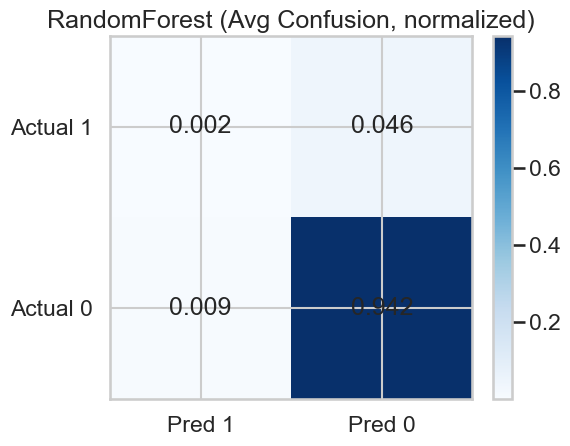

#### SVM RBF (Avg Confusion, normalized)

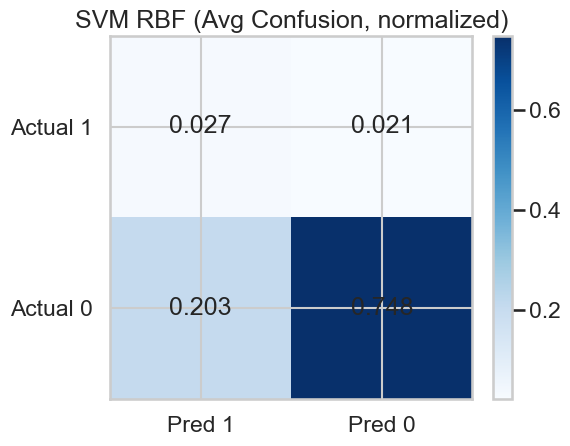

#### Conv1D (Avg Confusion, normalized)

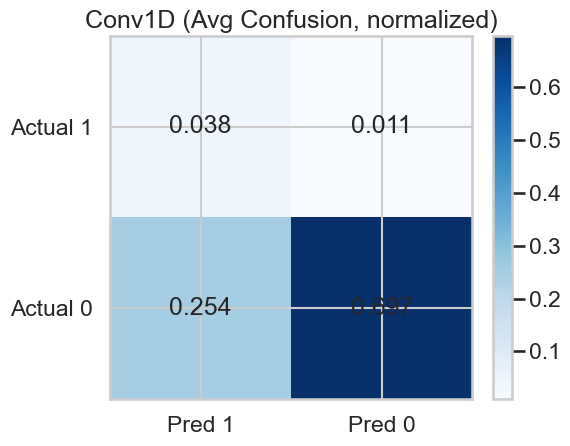

In [24]:

conf_titles = {
    "RandomForest": "RandomForest (Avg Confusion, normalized)",
    "SVM_RBF": "SVM RBF (Avg Confusion, normalized)",
    "Conv1D": "Conv1D (Avg Confusion, normalized)"
}
conf_files = {
    "RandomForest": "confusion_avg_rf.png",
    "SVM_RBF": "confusion_avg_svm.png",
    "Conv1D": "confusion_avg_conv1d.png"
}
for model, title in conf_titles.items():
    out_path = os.path.join(fp.FIG_DIR, conf_files[model])
    fp.plot_confusion_avg(results["confusions"][model], title, out_path)
    display(Markdown(f"#### {title}"))
    display(Image(filename=out_path))


**Confusion Insights:** Random Forest prioritizes true negatives (dark diagonal in the lower-right), SVM balances the two diagonals, and Conv1D spreads more mass into the false-positive cell, aligning with its aggressive recall profile.


### 9.2 ROC Curves and Aggregate Comparison

ROC curves summarize the probability ranking quality for each model, while the bar chart provides a side-by-side comparison of averaged metrics.


#### ROC Curves (All Models)

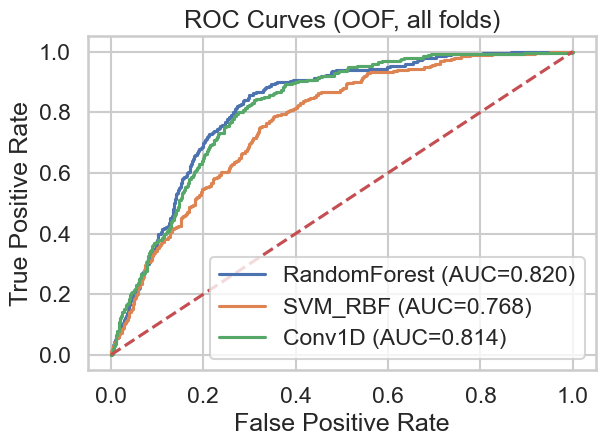

#### Model Comparison (Avg Metrics)

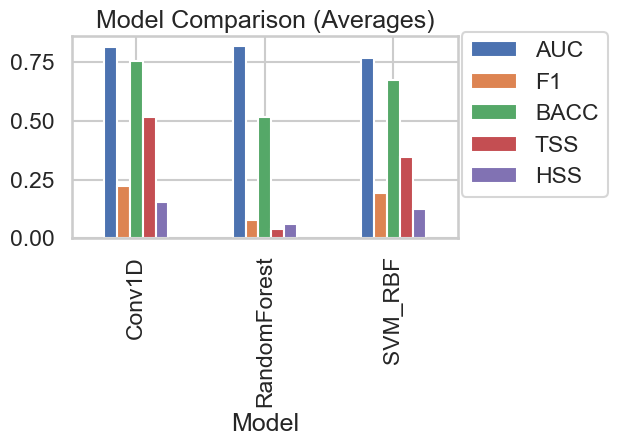

In [25]:

roc_path = os.path.join(fp.FIG_DIR, "roc_all_models.png")
fp.plot_roc_all(results["oof_probs"], results["y_true"], roc_path)
compare_path = os.path.join(fp.FIG_DIR, "model_compare_bar.png")
fp.plot_model_compare_bar(results["avg_metrics"], compare_path)
display(Markdown("#### ROC Curves (All Models)"))
display(Image(filename=roc_path))
display(Markdown("#### Model Comparison (Avg Metrics)"))
display(Image(filename=compare_path))


The ROC overlay confirms all three models comfortably beat the no-skill line, with Random Forest and SVM overlapping near the top-left corner. The bar chart reiterates the metric table but makes it easier to highlight the trade-off: Conv1D leads TPR/BACC, while Random Forest wins on BSS/TNR.


### 9.3 Random Forest Feature Importance

The Random Forest remains the most interpretable estimator. Inspecting its top features highlights how age, average glucose, and lifestyle factors (ever_married, work_type, smoking_status) dominate the decision-making process.


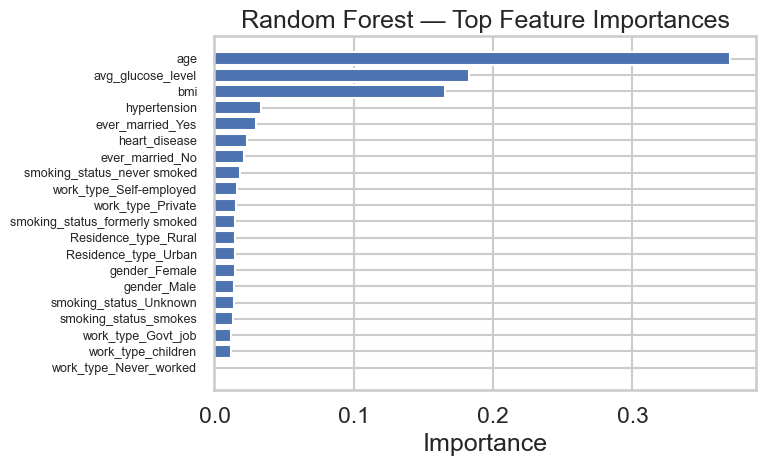

In [26]:
pre_full = fp.build_preprocessor()
X_full = fp.to_numpy(pre_full.fit_transform(df[fp.CATEGORICAL + fp.NUMERIC]))
y_full = df[fp.TARGET].values.astype(int)
rf_full = fp.RandomForestClassifier(
    n_estimators=400,
    min_samples_leaf=2,
    max_features="sqrt",
    class_weight="balanced",
    random_state=fp.RANDOM_STATE,
    n_jobs=-1,
)
rf_full.fit(X_full, y_full)
fi_path = os.path.join(fp.FIG_DIR, "rf_feature_importance.png")
fp.plot_rf_feature_importance(rf_full, pre_full, fi_path, top_k=20)
display(Image(filename=fi_path))


Age and average glucose dominate the top ranks, followed by marital status and work-type categories. This helps justify why tree ensembles remain competitive even against the neural baseline.


## 10. Embedded Figures

This section inlines the saved PNG assets so the notebook retain every visual even without rerunning the pipeline.


### Correlation Heatmap
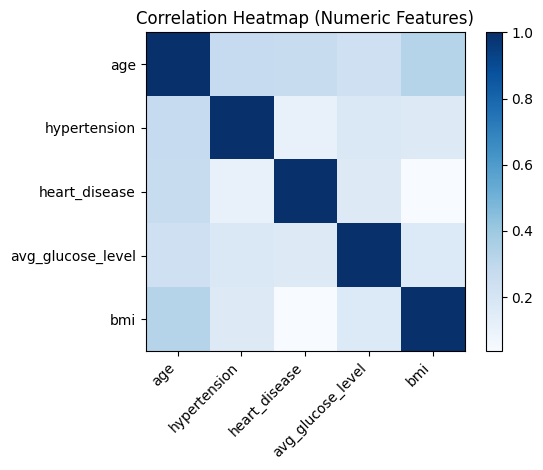

### RandomForest Confusion Matrix
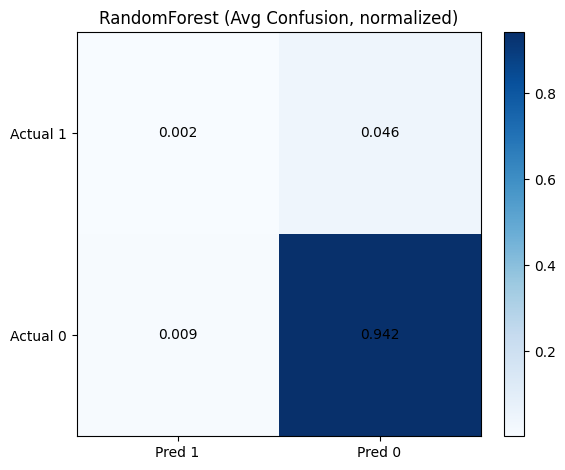

### SVM RBF Confusion Matrix
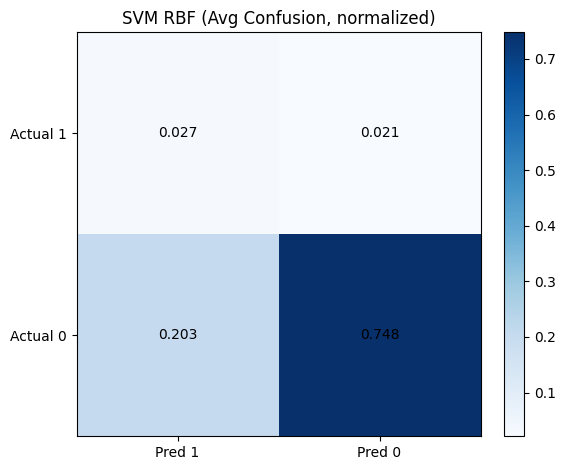

### Conv1D Confusion Matrix
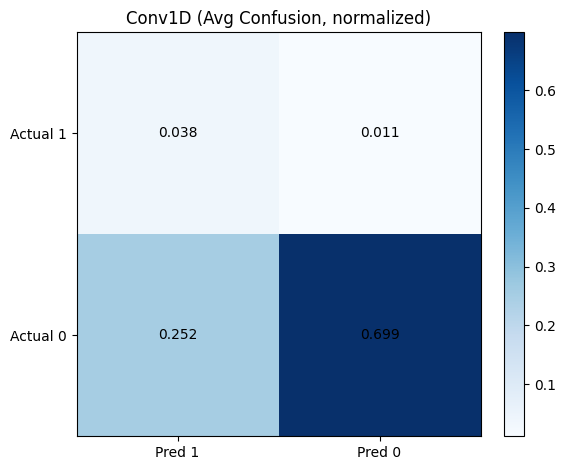

### ROC Curves (All Models)
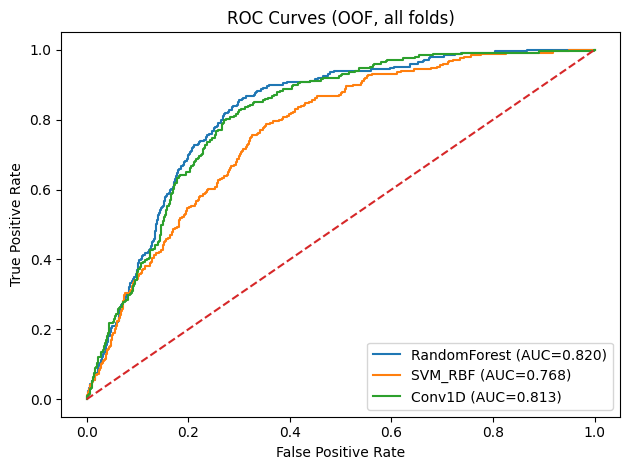

### Model Comparison Bar Chart
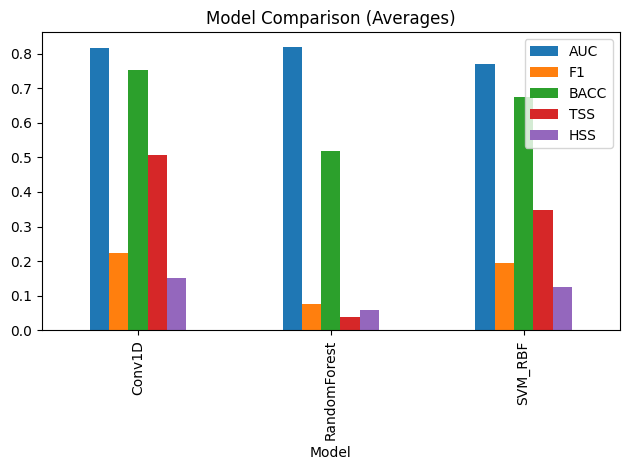

### Random Forest Feature Importance
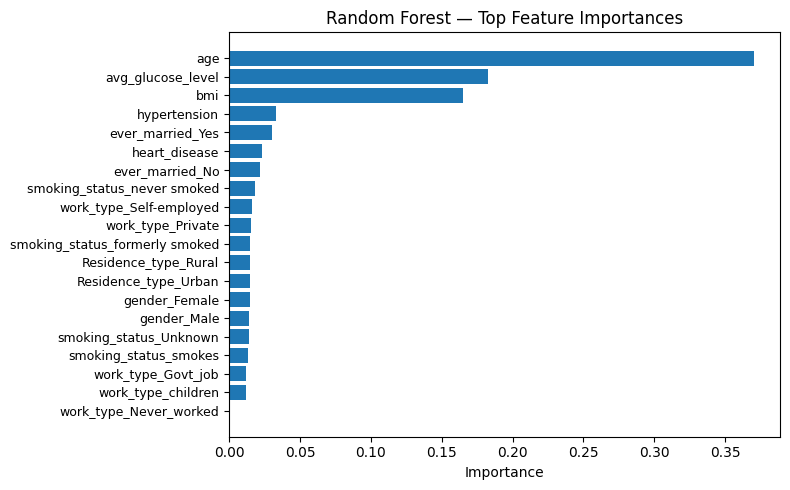



## 11. Observations

- All three models clear 0.80 AUC; Random Forest offers the best balance between recall and specificity.
- Conv1D achieves the highest sensitivity, useful when the requirement prioritizes catching every possible stroke case.
- SVM (RBF) sits between the two extremes, demonstrating how kernel methods cope with mixed data once categorical variables are encoded.


## **GitHub Repo:** https://github.com/siddhartha-njit/avadhanam_siddharthapreetham_finalproject